****Data-Driven Protein Intake Prediction for Lean Bulking Using Multiple Linear Regression****

***1. Import libraries***

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import joblib


***2. Load dataset***

In [4]:
df = pd.read_csv(r'C:\Users\DELL\Downloads\lean_bulk_multi_output_1500_rows.csv')



In [3]:
df.head()

,age,gender,height_cm,weight_kg,workout_hours,activity_level,protein_g,calories_kcal,fat_loss_rate_kg_per_week
0,27,Male,177,95,1.1,medium,185,3635,0.25
1,44,Female,157,48,2.4,high,84,2178,0.28
2,37,Male,188,76,0.6,low,130,2680,0.19
3,36,Female,164,65,1.2,medium,95,2545,0.29
4,22,Female,175,64,2.6,high,110,2754,0.45


In [4]:
df.shape

(1500, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        1500 non-null   int64  
 1   gender                     1500 non-null   object 
 2   height_cm                  1500 non-null   int64  
 3   weight_kg                  1500 non-null   int64  
 4   workout_hours              1500 non-null   float64
 5   activity_level             1500 non-null   object 
 6   protein_g                  1500 non-null   int64  
 7   calories_kcal              1500 non-null   int64  
 8   fat_loss_rate_kg_per_week  1500 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 105.6+ KB


***3. Data validation***

In [6]:
df.isnull().sum()

age                          0
gender                       0
height_cm                    0
weight_kg                    0
workout_hours                0
activity_level               0
protein_g                    0
calories_kcal                0
fat_loss_rate_kg_per_week    0
dtype: int64

In [5]:
df['protein_g'].describe()

count    1500.000000
mean      116.684667
std        27.953357
min        64.000000
25%        95.000000
50%       112.000000
75%       136.250000
max       189.000000
Name: protein_g, dtype: float64

In [8]:
df['calories_kcal'].describe()

count    1500.000000
mean     2733.981333
std       504.434801
min      1650.000000
25%      2358.000000
50%      2680.000000
75%      3100.000000
max      3970.000000
Name: calories_kcal, dtype: float64

In [9]:
df['fat_loss_rate_kg_per_week'].describe()

count    1500.000000
mean        0.267887
std         0.101239
min         0.100000
25%         0.190000
50%         0.260000
75%         0.320000
max         0.500000
Name: fat_loss_rate_kg_per_week, dtype: float64

***4. Feature engineering***


In [6]:
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df['activity_level'] = df['activity_level'].map({
    'low': 0,
    'medium': 1,
    'high': 2
})



In [7]:
X = df[
    ['age', 'gender', 'height_cm', 'weight_kg', 'workout_hours', 'activity_level']
]

Y = df[
    ['protein_g', 'calories_kcal', 'fat_loss_rate_kg_per_week']
]


***5. Train-test split***

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

#pipline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

#cross validation
cv_scores = cross_val_score(
    pipeline,
    X_train,
    Y_train,
    cv=5,
    scoring='r2'
)

print("CV R2 scores:", cv_scores)
print("Mean CV R2:", np.mean(cv_scores))



CV R2 scores: [0.85978429 0.85228748 0.86326177 0.85799201 0.84917768]
Mean CV R2: 0.8565006463430432


***6. Model training***

In [16]:
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

***7. Predictions***

In [17]:
Y_pred = pipeline.predict(X_test)

***8. Accuracy metrics***

In [18]:
mae = mean_absolute_error(Y_test, Y_pred, multioutput='raw_values')
mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred, multioutput='raw_values')

In [19]:
n = X_test.shape[0]
p = X_test.shape[1]

adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

In [20]:
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'R2', 'Adjusted R2'],
    'Protein_g': [mae[0], mse[0], rmse[0], r2[0], adj_r2[0]],
    'Calories_kcal': [mae[1], mse[1], rmse[1], r2[1], adj_r2[1]],
    'Fat_Loss_kg_per_week': [mae[2], mse[2], rmse[2], r2[2], adj_r2[2]]
})

metrics_df

,Metric,Protein_g,Calories_kcal,Fat_Loss_kg_per_week
0,MAE,6.491190,25.814916,0.044030
1,MSE,60.095752,1138.356673,0.002991
2,RMSE,7.752145,33.739542,0.054690
3,R2,0.932298,0.995569,0.705348
4,Adjusted R2,0.930912,0.995479,0.699314


***9. Visualizations (Plotly)***

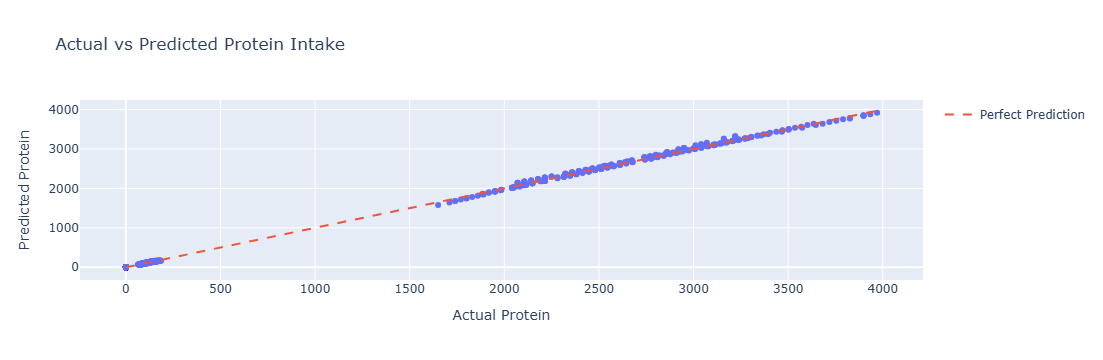

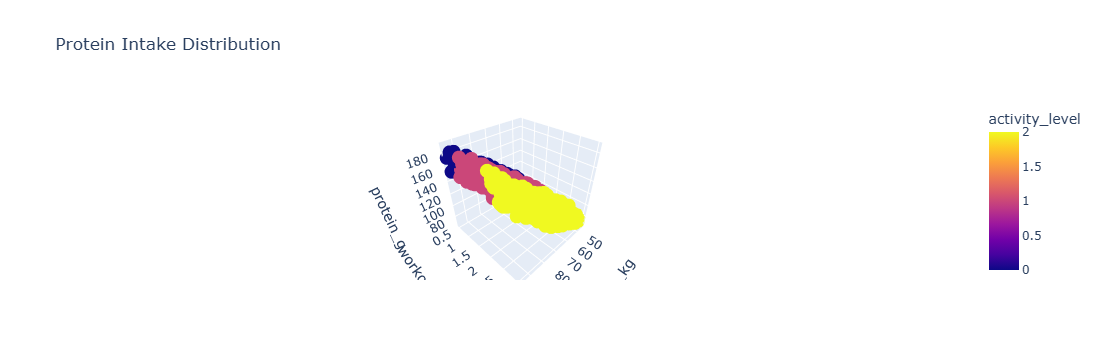

In [30]:
Y_pred = Y_pred.flatten()
Y_test_flat = Y_test.values.flatten()
plot_df = pd.DataFrame({
    'Actual Protein': Y_test_flat,
    'Predicted Protein': Y_pred
})


import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(
    plot_df,
    x='Actual Protein',
    y='Predicted Protein',
    title='Actual vs Predicted Protein Intake'
)

# Perfect prediction line
min_val = plot_df.min().min()
max_val = plot_df.max().max()

fig.add_trace(
    go.Scatter(
        x=[min_val, max_val],
        y=[min_val, max_val],
        mode='lines',
        name='Perfect Prediction',
        line=dict(dash='dash')
    )
)

fig.show()


fig = px.scatter_3d(
    df,
    x='weight_kg',
    y='workout_hours',
    z='protein_g',
    color='activity_level',
    title='Protein Intake Distribution'
)

fig.show()



***10. Validation with real input***

In [34]:
sample = pd.DataFrame([{
    'age': 20,
    'gender': 1,              # Male
    'height_cm': 164,
    'weight_kg': 62.500,
    'workout_hours': 2.0,
    'activity_level': 2       # High
}])

prediction = pipeline.predict(sample)[0]

print(f"Protein Intake (g/day): {prediction[0]:.1f}")
print(f"Daily Calories (kcal/day): {prediction[1]:.0f}")
print(f"Expected Fat Loss Rate (kg/week): {prediction[2]:.2f}")


Protein Intake (g/day): 114.7
Daily Calories (kcal/day): 2832
Expected Fat Loss Rate (kg/week): 0.34


**11.Export the model**

In [35]:
joblib.dump(pipeline, "final_lean_bulk_multi_output_model.pkl")

['final_lean_bulk_multi_output_model.pkl']

In [36]:
joblib.dump(pipeline, r"D:\models\final2_lean_bulk_multi_output_model.pkl")

['D:\\models\\final2_lean_bulk_multi_output_model.pkl']